In [3]:
import time
import numpy as np 
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tensorflow as tf
import datetime
import seaborn as sns

%matplotlib inline

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

SEED_RAND = 41
np.random.seed(SEED_RAND)
tf.random.set_seed(SEED_RAND)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print('--import complete--')

input_path = 'D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/'
train_GT_path = 'D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/DataSet/'

def normalize_image (img_path):
    image = cv2.imread(img_path)    #load image pointer
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #transform to RGB and make type=nparray
    ##image = exposure.equalize_adapthist(image, clip_limit=0.1)  ##normalize contrast of images
    image = cv2.resize(image, (width, height))   ##normalize size of all images

    return image




Num GPUs Available:  0
--import complete--


(39209, 11)
       Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
15553     38      38       6       6      33      33       10   
27276     30      31       5       6      24      25       21   
27522     51      47       6       5      46      42       22   
3571      31      33       5       6      26      28        2   
350       48      46       6       6      43      41       20   

                                                    Path         Type  \
15553  D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignmen...  prohibitory   
27276  D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignmen...       danger   
27522  D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignmen...       danger   
3571   D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignmen...  prohibitory   
350    D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignmen...       danger   

                        Label  TypeId  
15553  no overtaking (trucks)       1  
27276                    bend       0  
27522             uneven road       0 

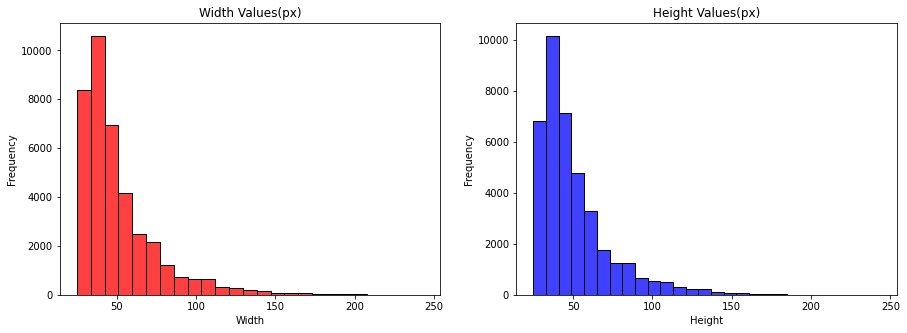

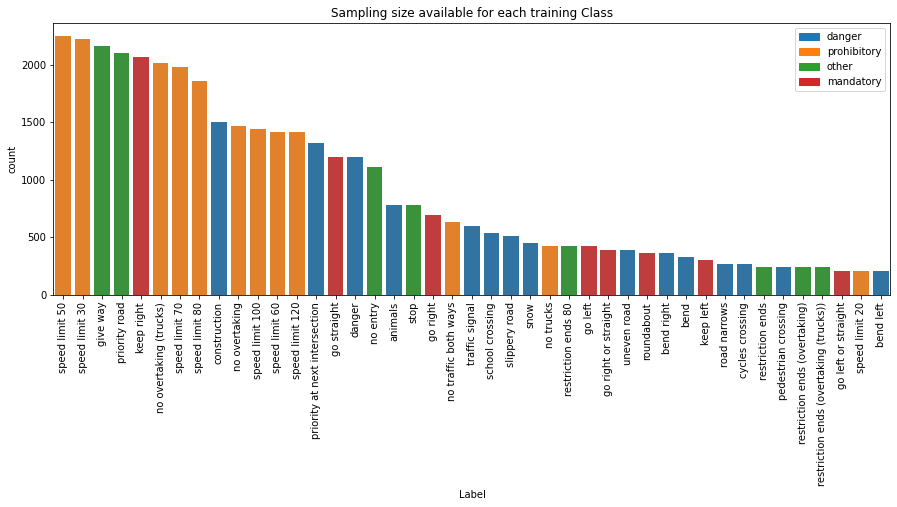

In [5]:
#load description for every ClassID
#https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/code
GTSRBInfo = pd.DataFrame({
    0:  { 'Type': 'prohibitory',  'Label': "speed limit 20"                         },
    1:  { 'Type': 'prohibitory',  'Label': "speed limit 30"                         },
    2:  { 'Type': 'prohibitory',  'Label': "speed limit 50"                         },
    3:  { 'Type': 'prohibitory',  'Label': "speed limit 60"                         },
    4:  { 'Type': 'prohibitory',  'Label': "speed limit 70"                         },
    5:  { 'Type': 'prohibitory',  'Label': "speed limit 80"                         },
    6:  { 'Type': 'other',        'Label': "restriction ends 80"                    },
    7:  { 'Type': 'prohibitory',  'Label': "speed limit 100"                        },
    8:  { 'Type': 'prohibitory',  'Label': "speed limit 120"                        },
    9:  { 'Type': 'prohibitory',  'Label': "no overtaking"                          },
    10: { 'Type': 'prohibitory',  'Label': "no overtaking (trucks)"                 },
    11: { 'Type': 'danger',       'Label': "priority at next intersection"          },
    12: { 'Type': 'other',        'Label': "priority road"                          },
    13: { 'Type': 'other',        'Label': "give way"                               },
    14: { 'Type': 'other',        'Label': "stop"                                   },
    15: { 'Type': 'prohibitory',  'Label': "no traffic both ways"                   },
    16: { 'Type': 'prohibitory',  'Label': "no trucks"                              },
    17: { 'Type': 'other',        'Label': "no entry"                               },
    18: { 'Type': 'danger',       'Label': "danger"                                 },
    19: { 'Type': 'danger',       'Label': "bend left"                              },
    20: { 'Type': 'danger',       'Label': "bend right"                             },
    21: { 'Type': 'danger',       'Label': "bend"                                   },
    22: { 'Type': 'danger',       'Label': "uneven road"                            },
    23: { 'Type': 'danger',       'Label': "slippery road"                          },
    24: { 'Type': 'danger',       'Label': "road narrows"                           },
    25: { 'Type': 'danger',       'Label': "construction"                           },
    26: { 'Type': 'danger',       'Label': "traffic signal"                         },
    27: { 'Type': 'danger',       'Label': "pedestrian crossing"                    },
    28: { 'Type': 'danger',       'Label': "school crossing"                        },
    29: { 'Type': 'danger',       'Label': "cycles crossing"                        },
    30: { 'Type': 'danger',       'Label': "snow"                                   },
    31: { 'Type': 'danger',       'Label': "animals"                                },
    32: { 'Type': 'other',        'Label': "restriction ends"                       },
    33: { 'Type': 'mandatory',    'Label': "go right"                               },
    34: { 'Type': 'mandatory',    'Label': "go left"                                },
    35: { 'Type': 'mandatory',    'Label': "go straight"                            },
    36: { 'Type': 'mandatory',    'Label': "go right or straight"                   },
    37: { 'Type': 'mandatory',    'Label': "go left or straight"                    },
    38: { 'Type': 'mandatory',    'Label': "keep right"                             },
    39: { 'Type': 'mandatory',    'Label': "keep left"                              },
    40: { 'Type': 'mandatory',    'Label': "roundabout"                             },
    41: { 'Type': 'other',        'Label': "restriction ends (overtaking)"          },
    42: { 'Type': 'other',        'Label': "restriction ends (overtaking (trucks))" },
}).T

#Add ClassID as column
GTSRBInfo = GTSRBInfo[:]

GTSRBInfo.index.name = 'ClassId'
GTSRBInfo.reset_index(inplace=True)

# Transform 'Label' into category data type
GTSRBInfo['Label'] = GTSRBInfo.Label.astype('category')

# oder in crescent order accordingly to data amount of each category
Types = GTSRBInfo.Type.value_counts().index
GTSRBInfo['Type'] = GTSRBInfo.Type.astype('category').cat.reorder_categories(Types)
GTSRBInfo['TypeId'] = GTSRBInfo.Type.cat.codes

GTSRBInfo

# load train CSV (local files)
GTSRB = pd.read_csv(train_GT_path + "Train.csv")
GTSRB.Path = train_GT_path + GTSRB.Path
GTSRB = GTSRB.merge(GTSRBInfo, on="ClassId")

# List available signs 
Labels = GTSRB.Label.value_counts().index
print(GTSRB.shape)
print(GTSRB.sample(5))#pick 5 samples of the Ground truth label dataset
print(GTSRB[['Width', 'Height']].describe()) # simple statistics of the dataset available

#plot histogram of image sample availabe in training dataset
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharex=True)

sns.histplot(
    GTSRB.Width,
    bins=25,
    kde=False,
    color='red',
    ax=axs[0],
)
axs[0].set_title("Width Values(px)")
axs[0].set_xlabel("Width")
axs[0].set_ylabel("Frequency")

sns.histplot(
    GTSRB.Height,
    bins=25,
    kde=False,
    color='blue',
    ax=axs[1]
)
axs[1].set_title("Height Values(px)")
axs[1].set_xlabel("Height")
axs[1].set_ylabel("Frequency")

plt.show()

#plot total of sample for each class in the dataset

plt.figure(figsize=(15, 5))
plt.xticks(rotation=90)

LabelsType = GTSRBInfo.set_index('Label').loc[Labels].TypeId
palette = np.asarray(sns.color_palette())[LabelsType]

sns.countplot(
    x='Label',
    data=GTSRB,
    palette=palette,
    order=Labels,
).set_title("Sampling size available for each training Class")

plt.legend(handles=[
    mpatches.Patch(color=barColor, label=barType)
    for barColor, barType
    in zip(sns.color_palette(), Types)
])

plt.show()

----Start: 
D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00000
Error - Image loading
210


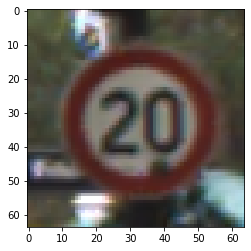

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00001
1710


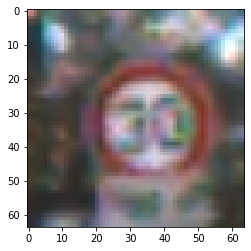

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00002
3210


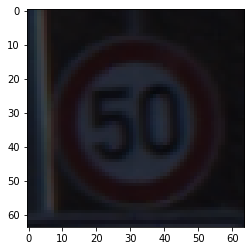

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00003
Error - Image loading
4620


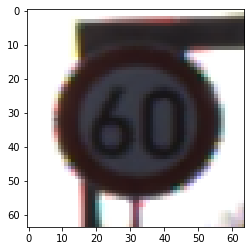

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00004
6120


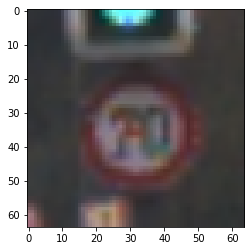

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00005
7620


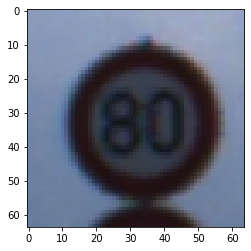

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00006
Error - Image loading
8040


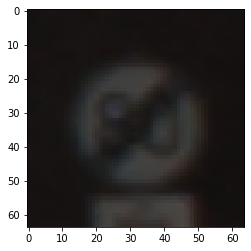

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00007
Error - Image loading
9480


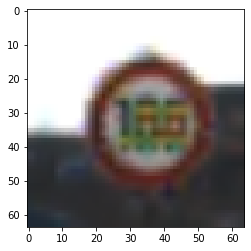

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00008
Error - Image loading
10890


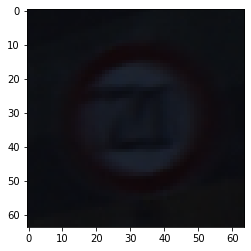

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00009
Error - Image loading
12360


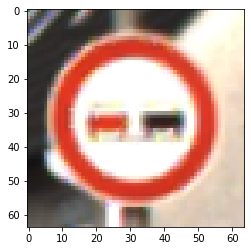

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00010
13860


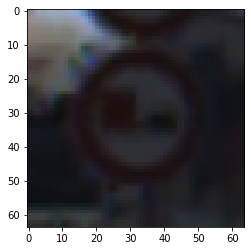

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00011
Error - Image loading
15180


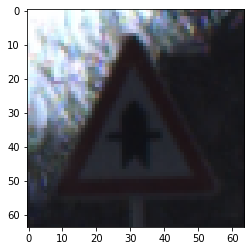

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00012
16680


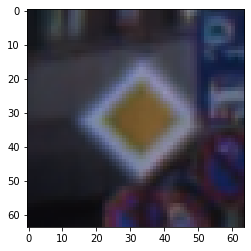

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00013
18180


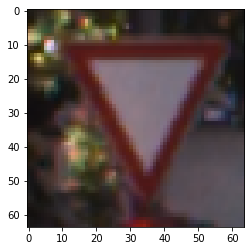

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00014
Error - Image loading
18960


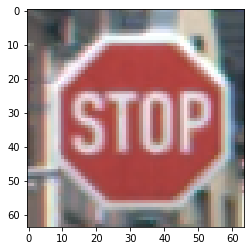

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00015
Error - Image loading
19590


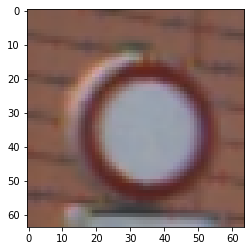

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00016
Error - Image loading
20010


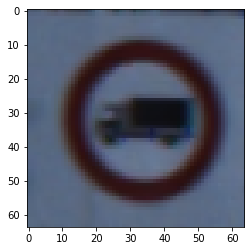

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00017
Error - Image loading
21120


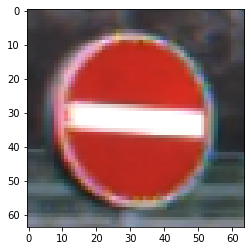

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00018
Error - Image loading
22320


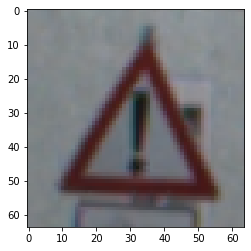

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00019
Error - Image loading
22530


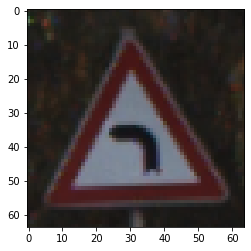

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00020
Error - Image loading
22890


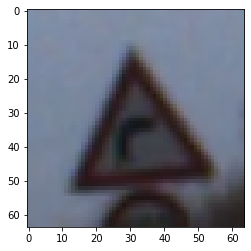

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00021
Error - Image loading
23220


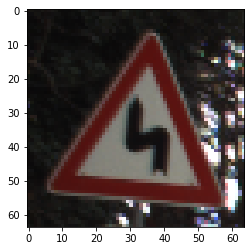

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00022
Error - Image loading
23610


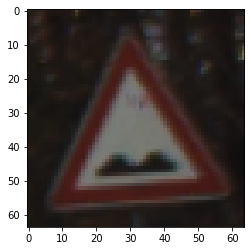

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00023
Error - Image loading
24120


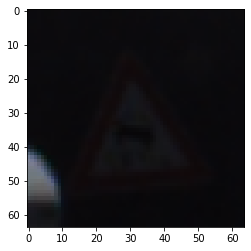

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00024
Error - Image loading
24390


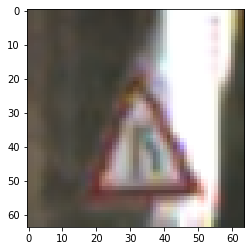

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00025
25890


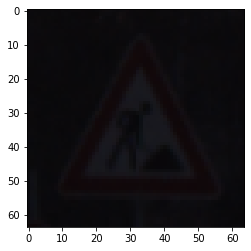

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00026
Error - Image loading
26490


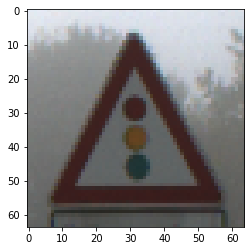

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00027
Error - Image loading
26730


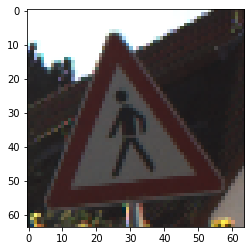

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00028
Error - Image loading
27270


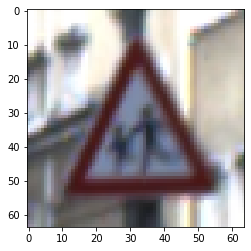

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00029
Error - Image loading
27540


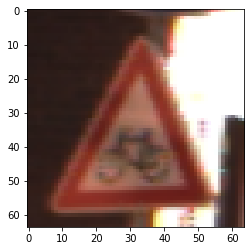

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00030
Error - Image loading
27990


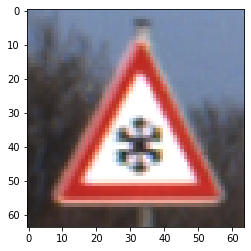

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00031
Error - Image loading
28770


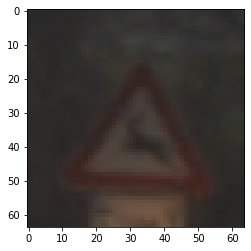

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00032
Error - Image loading
29010


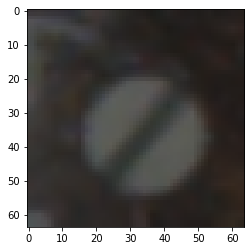

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00033
Error - Image loading
29699


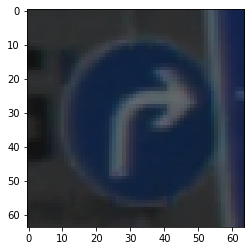

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00034
Error - Image loading
30119


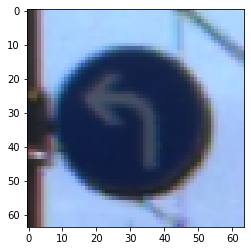

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00035
Error - Image loading
31319


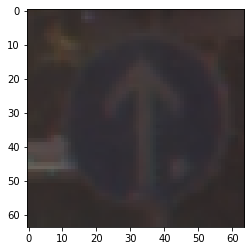

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00036
Error - Image loading
31709


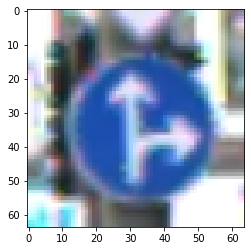

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00037
Error - Image loading
31919


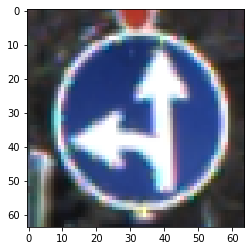

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00038
33419


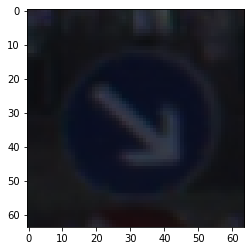

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00039
Error - Image loading
33719


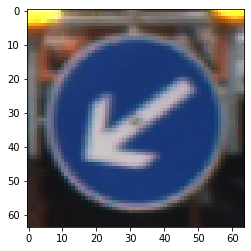

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00040
Error - Image loading
34079


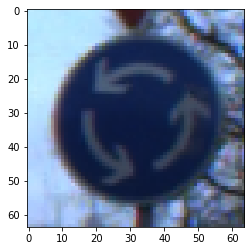

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00041
Error - Image loading
34319


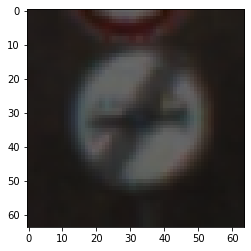

D:/PELUSO/ITSligo/lectures_MENG/3-ML/assignment 2/training/GTSRB/Final_Training/Images/00042
Error - Image loading
34559


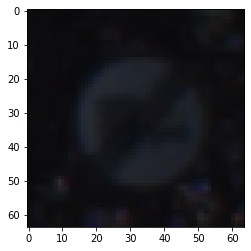

(34559, 64, 64, 3) (34559,)
It has taken 207.96466 seconds
--load complete, shuffling data--
X_train.shape (29375, 64, 64, 3)
X_valid.shape (5184, 64, 64, 3)
y_train.shape (29375,)
y_valid.shape (5184,)
(29375, 43)
(5184, 43)


In [9]:
##--load images from local file --

total_classes = 43
off_set_class = 0 #start index
Max_index_set = 1500    #number of elements to train in each class (max=-1)
height = 64
width = 64
channels = 3

start = time.time()
image_data = []
image_labels = []


print('----Start: ')
for i in range(total_classes):
    path = input_path + 'training/GTSRB/Final_Training/Images/' + str(i+off_set_class).zfill(5)
    print(path)
    images = os.listdir(path)
    category_size = len(images[:Max_index_set])
    
    for img in images[:Max_index_set]: #limited
        try:
            image_treated = normalize_image(path + '/' + img)
            image_data.append(np.array(image_treated))
            image_labels.append(i+off_set_class)    ##offset index as in original path
            #print(img + ' : ' + str(i+off_set_class))
            
        except:
            print("Error - Image loading")
    print(len(image_data))    
    plt.figure()
    plt.imshow(image_data[np.random.randint(len(image_data)-(category_size),len(image_data)-1)])#Plot a random sample
    plt.show()


#Converting lists into numpy arrays
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)
end = time.time()
print("It has taken", round(end-start,5), "seconds")

print('--load complete, shuffling data--')

shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

#Splitting training and testing dataset
X_train, X_valid, y_train, y_valid = train_test_split(image_data, image_labels, test_size=0.15, random_state=SEED_RAND, shuffle=True)

X_train = X_train/255 
X_valid = X_valid/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_valid.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_valid.shape)

#Converting the labels into one hot encoding
y_train = keras.utils.to_categorical(y_train, total_classes)
y_valid = keras.utils.to_categorical(y_valid, total_classes)

print(y_train.shape)
print(y_valid.shape)


In [10]:
#prepare TensorBoard log path and command line (copy and paste command into windows CMD)
log_dir = "./logs/a" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
print('tensorboard --logdir="' +os.path.abspath(log_dir) + '"' )



tensorboard --logdir="d:\PELUSO\ITSligo\lectures_MENG\3-ML\assignment 2\logs\a20210731-231413"


In [11]:
##--build model and run fit--

keras.backend.clear_session() # clearing session
np.random.seed(SEED_RAND) # generating random seed
tf.random.set_seed(SEED_RAND) # set.seed function helps reuse same set of random variables
print('--randomization done--')

##-- set each class weight to support the inbalance of training dataset
## smaller sets get more weight to compensate its size
classTotals = y_train.sum(axis=0)
classWeights = classTotals.max() / classTotals

classWeight = {
    i: classWeight
    for i, classWeight in enumerate(classWeights)
}
print('classWeight: ' + str(classWeight))


#---VGG16 pre-trained---

baseModel = VGG16(input_shape=(height,width,channels),weights='imagenet',include_top=False)#,classes=total_classes)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
baseModel.trainable = False

# construct the head of the model that will be placed on top of the base model
OutputModel = baseModel.output

# add new classifier layers
flat1 = Flatten()(OutputModel)
class1 = Dense(256, activation='relu')(flat1)
output = Dense(total_classes, activation='softmax')(class1)
# define new model
model = keras.models.Model(inputs=baseModel.inputs, outputs=output)

model.summary()


--randomization done--
classWeight: {0: 7.0163937, 1: 1.0134175, 2: 1.0150198, 3: 1.0629139, 4: 1.0078493, 5: 1.0158228, 6: 3.4702702, 7: 1.0439024, 8: 1.0708925, 9: 1.0296712, 10: 1.0, 11: 1.1484795, 12: 1.0015601, 13: 1.008641, 14: 1.954338, 15: 2.4226415, 16: 3.6373937, 17: 1.3333334, 18: 1.2650247, 19: 7.254237, 20: 4.2943144, 21: 4.635379, 22: 4.0125, 23: 3.035461, 24: 5.5584416, 25: 1.0070589, 26: 2.4597702, 27: 6.2941175, 28: 2.7792208, 29: 5.51073, 30: 3.3264248, 31: 1.9454546, 32: 6.2941175, 33: 2.2330434, 34: 3.6581197, 35: 1.2526829, 36: 3.7876105, 37: 7.0163937, 38: 1.0118203, 39: 5.136, 40: 4.1286173, 41: 6.263415, 42: 6.056604}
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792     

In [12]:
# #Compilation of the model

batch_size = 32
epochs = 200 
Learning_rate = 1e-3  
Momentum=0.9
LR_decay = (Learning_rate/(1.5 * epochs))

opt = keras.optimizers.SGD(lr=Learning_rate,momentum=Momentum, decay=LR_decay)#Adam is not recommended;
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])   #['accuracy','mse']

#--- prepare callbacks ---
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min')#val_accuracy#accuracy#loss; period=1
early = EarlyStopping(monitor='loss',patience=10, verbose=1, mode='min', min_delta=0.001)# restore_best_weights= True, min_delta=0.01, , patience=3, baseline=0.1
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
#---

history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_valid,y_valid),
    class_weight=classWeight,
    callbacks=[checkpoint, early, tensorboard_callback]
)

print('---training complete---')
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # setting limits for y-axis
plt.show()



Epoch 1/200
918/918 [==============================] - ETA: 0s - loss: 4.4049 - accuracy: 0.3141
Epoch 00001: loss improved from inf to 4.40487, saving model to vgg16_1.h5
918/918 [==============================] - 413s 450ms/step - loss: 4.4049 - accuracy: 0.3141 - val_loss: 1.8360 - val_accuracy: 0.4354
Epoch 2/200
918/918 [==============================] - ETA: 0s - loss: 2.8576 - accuracy: 0.5044
Epoch 00002: loss improved from 4.40487 to 2.85763, saving model to vgg16_1.h5
918/918 [==============================] - 429s 467ms/step - loss: 2.8576 - accuracy: 0.5044 - val_loss: 1.5794 - val_accuracy: 0.5058
Epoch 3/200
918/918 [==============================] - ETA: 0s - loss: 2.2809 - accuracy: 0.5841
Epoch 00003: loss improved from 2.85763 to 2.28087, saving model to vgg16_1.h5
918/918 [==============================] - 592s 645ms/step - loss: 2.2809 - accuracy: 0.5841 - val_loss: 1.2533 - val_accuracy: 0.6115
Epoch 4/200
918/918 [==============================] - ETA: 0s - loss: 

KeyboardInterrupt: 

In [13]:
#print each class accuracy individually

start = time.time()
test = pd.read_csv(input_path + 'GT-final_test.CSV', sep=';')

#simple dictionary to label all traffic signs class.
classes = { 
            0:'Speedlimit(20km/h)',
            1:'Speedlimit(30km/h)',
            2:'Speedlimit(50km/h)',
            3:'Speedlimit(60km/h)',
            4:'Speedlimit(70km/h)',
            5:'Speedlimit(80km/h)',
            6:'Endofspeedlimit(80km/h)',
            7:'Speedlimit(100km/h)',
            8:'Speedlimit(120km/h)',
            9:'Nopassing',
            10:'Nopassingvehover3.5tons',
            11:'Right-of-wayatintersection',
            12:'Priorityroad',
            13:'Yield',
            14:'Stop',
            15:'Novehicles',
            16:'Veh>3.5tonsprohibited',
            17:'Noentry',
            18:'Generalcaution',
            19:'Dangerouscurveleft',
            20:'Dangerouscurveright',
            21:'Doublecurve',
            22:'Bumpyroad',
            23:'Slipperyroad',
            24:'Roadnarrowsontheright',
            25:'Roadwork',
            26:'Trafficsignals',
            27:'Pedestrians',
            28:'Childrencrossing',
            29:'Bicyclescrossing',
            30:'Bewareofice/snow',
            31:'Wildanimalscrossing',
            32:'Endspeed+passinglimits',
            33:'Turnrightahead',
            34:'Turnleftahead',
            35:'Aheadonly',
            36:'Gostraightorright',
            37:'Gostraightorleft',
            38:'Keepright',
            39:'Keepleft',
            40:'Roundaboutmandatory',
            41:'Endofnopassing',
            42:'Endnopassingveh>3.5tons'}

print('--predict--')

saved_model = tf.keras.models.load_model('vgg16_1.h5')

test = pd.read_csv(input_path + 'GT-final_test.csv',sep=';')
Max_load = -1#1000

labels = test["ClassId"].values

img_name = test["Filename"].values

Class_filter = range(off_set_class,total_classes)

for CF in Class_filter:
    start = time.time()
    data =[]
    label = []
    print('---')
    for index,img in enumerate(img_name[:Max_load]):
        if labels[index] != CF:
            continue
        
        try
            #print(str(labels[index]) + '  -  ' + str(index))
            label.append(labels[index]-0)##-1 = defect when training!!!
            image_treated = normalize_image(input_path +'test/GTSRB/Final_Test/Images/' + img)
            data.append(np.array(image_treated))
           
        except:
            print("Error")

    print("--ClassId: "+ str(CF) + ", size: " + str(len(data)))
    X_test = np.array(data)
    X_test = X_test/255

    #The predict_classes method is only available for the Sequential class (which is the class of your first model) but not for the Model class (the class of your second model).  With the Model class, you can use the predict method which will give you a vector of probabilities and then get the argmax of this vector (with np.argmax(y_pred1,axis=1))
    pred = saved_model.predict(X_test)
    pred = np.argmax(pred,axis=1)

    #Accuracy with the test data
    print("accuracy_score = ")
    print(accuracy_score(label, pred)*100)  #per cent
    end = time.time()
    print("It has taken", round(end-start,5), "seconds")

print('--end--')



--predict--
---
--ClassId: 0, size: 60
accuracy_score = 
56.666666666666664
It has taken 1.49762 seconds
---
--ClassId: 1, size: 720
accuracy_score = 
76.52777777777777
It has taken 15.99658 seconds
---
--ClassId: 2, size: 750
accuracy_score = 
49.333333333333336
It has taken 16.82542 seconds
---
--ClassId: 3, size: 450
accuracy_score = 
42.888888888888886
It has taken 9.74353 seconds
---
--ClassId: 4, size: 660
accuracy_score = 
57.72727272727273
It has taken 13.72766 seconds
---
--ClassId: 5, size: 630
accuracy_score = 
64.28571428571429
It has taken 13.6271 seconds
---
--ClassId: 6, size: 150
accuracy_score = 
65.33333333333333
It has taken 3.13161 seconds
---
--ClassId: 7, size: 450
accuracy_score = 
69.33333333333334
It has taken 10.00277 seconds
---
--ClassId: 8, size: 450
accuracy_score = 
71.77777777777777
It has taken 10.41199 seconds
---
--ClassId: 9, size: 480
accuracy_score = 
71.45833333333333
It has taken 10.35771 seconds
---
--ClassId: 10, size: 659
accuracy_score = 
81.

In [ ]:
print('--single test--')

for img_index in [243,252,403,579]:#test specific images in the test list
    #print(img_index)
    print(img_name[img_index])
    image_treated = normalize_image(input_path+ 'test/GTSRB/Final_Test/Images/' + img_name[img_index])
    img = np.array(image_treated)/255.
    img = img.reshape(1,height,width,channels)
    print(img.shape)
    plt.figure()
    plt.imshow(image_treated)

    pred = saved_model.predict(img)[0]  
    pred = pred +0##defect when training!!!
    pred = np.argmax(pred)
    print(pred)
    sign = classes[pred]
    print(sign)

print('---end of prediction---')
